In [73]:
import pandas as pd
import numpy as np
import matplotlib.style
import matplotlib.pyplot as plt
import yfinance as yf
from pandas.conftest import axis_1

pd.options.display.float_format = '{:.4f}'.format
plt.style.use("seaborn-v0_8")
from itertools import product

In [74]:
symbol = "USDGBP=X"
start = "2023-01-01"
end = "2024-01-01"

In [75]:
df = yf.download(symbol, start, end, interval='1d').Close.to_frame()
df.rename(columns={"Close": "price"}, inplace=True)
df['returns'] = np.log(df['price'].div(df['price'].shift(1)))
df

[*********************100%%**********************]  1 of 1 completed


,price,returns
Date,,
2023-01-02,0.8251,NaN
2023-01-03,0.8290,0.0048
2023-01-04,0.8354,0.0078
2023-01-05,0.8294,-0.0073
2023-01-06,0.8395,0.0121
...,...,...
2023-12-25,0.7888,0.0006
2023-12-26,0.7871,-0.0022
2023-12-27,0.7857,-0.0018


In [76]:
class BollingerBandStrategy():
    def __init__(self, rawdata, sma, dev):        
        self.rawdata = rawdata
        self.sma = sma
        self.dev = dev
        
        self.processed = self.get_processed()    
    
    def get_processed(self):
        df = self.rawdata.copy()
        
        spread = 1.5 * 0.0001
        halfspread = spread / 2
        ptc = halfspread / df.price.mean()
        
        df['sma'] = df['price'].rolling(window=self.sma).mean()
        df['lower'] = df['sma'] - df['price'].rolling(self.sma).std() * self.dev
        df['upper'] = df['sma'] + df['price'].rolling(self.sma).std() * self.dev
        def bollinger_position(price, lower, upper):
            if price < lower: return 1  # oversold -> go long
            if price > upper: return -1  # oversold -> go long
            else: return np.nan  
        df['distance'] = df.price - df.sma
        df['position'] = df.apply(lambda x: bollinger_position(x.price, x.lower, x.upper), axis=1)
        df['position'] = np.where(df.distance * df.distance.shift(1) < 0,  0, df['position'])
        df.position = df.position.ffill().fillna(0)
        df['strategy'] = df.position.shift(1) * df['returns']
        df['trades'] = df.position.diff().fillna(0).abs()
        df.dropna(inplace=True)
        df['creturns'] = df['returns'].cumsum().apply(np.exp)
        df['cstrategy'] = df['strategy'].cumsum().apply(np.exp)
        df['strategy_net'] = df.strategy - df.trades*ptc
        df['cstrategy_net'] = df.strategy_net.cumsum().apply(np.exp)
        return df
    
    def plot_data(self):
        self.processed[['creturns', 'cstrategy_net']].plot(figsize=(12, 8))
        plt.show()
        
        

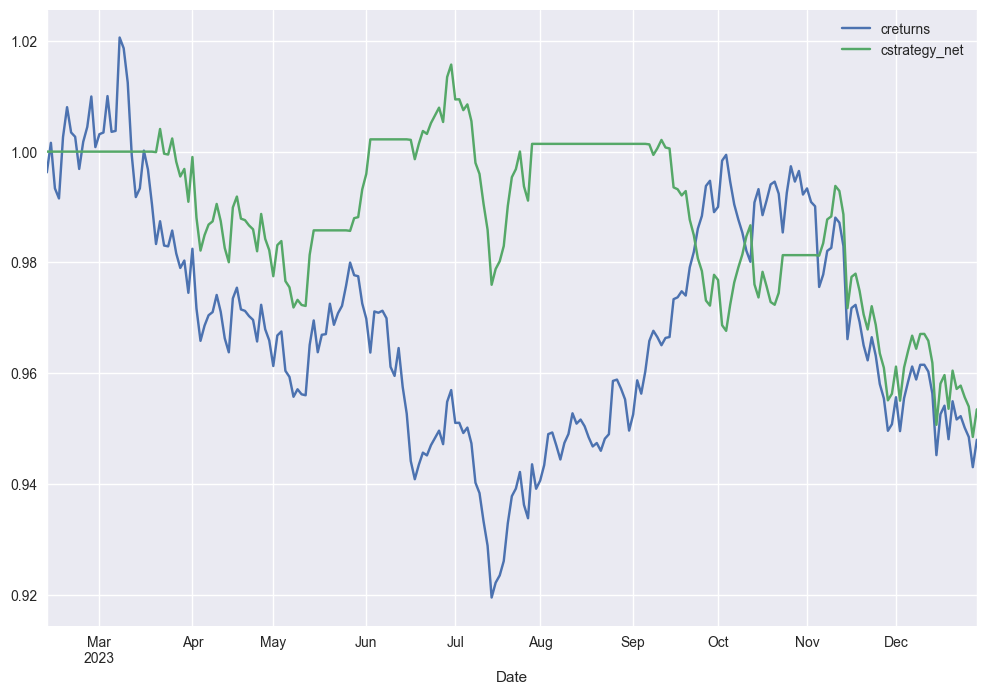

In [77]:
first = BollingerBandStrategy(df, 30, 2)
first.processed['cstrategy_net'].iloc[-1]
first.plot_data()

In [78]:
def optimize_bollinger():
    sma_range = range(2,100,1)
    dev_range = range(1,4,1)
    combinations = list(product(sma_range, dev_range))
    resultsDf = pd.DataFrame(columns=['sma', 'dev', 'cstrategy_net', 'cagr'])
    
    for combination in combinations:
        s = BollingerBandStrategy(df, combination[0], combination[1])
        resultDict =  {
            'sma': combination[0],
            'dev': combination[1],
            'cstrategy_net': s.processed['cstrategy_net'].iloc[-1],
            'cagr': s.processed['strategy_net'].mean() * 252
        }
        resultsDf.loc[len(resultsDf)] = resultDict
    return resultsDf

results = optimize_bollinger()
results

,sma,dev,cstrategy_net,cagr
0,2,1,1.0000,0.0000
1,2,2,1.0000,0.0000
2,2,3,1.0000,0.0000
3,3,1,1.0563,0.0535
4,3,2,1.0000,0.0000
...,...,...,...,...
289,98,2,1.0371,0.0563
290,98,3,1.0000,0.0000
291,99,1,0.9964,-0.0056
292,99,2,1.0371,0.0567


<Axes: >

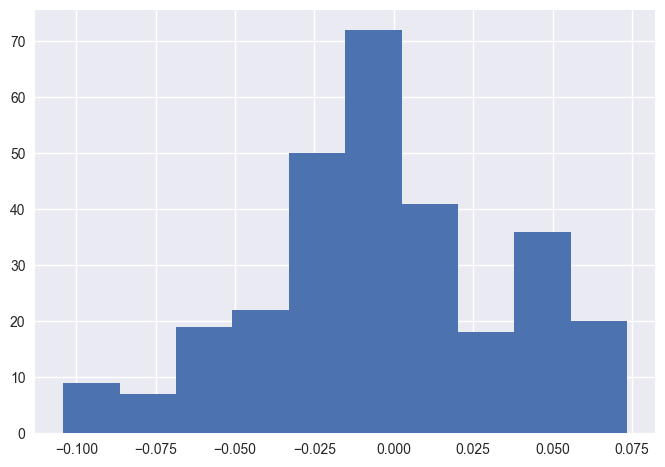

In [79]:
results.cagr.hist()


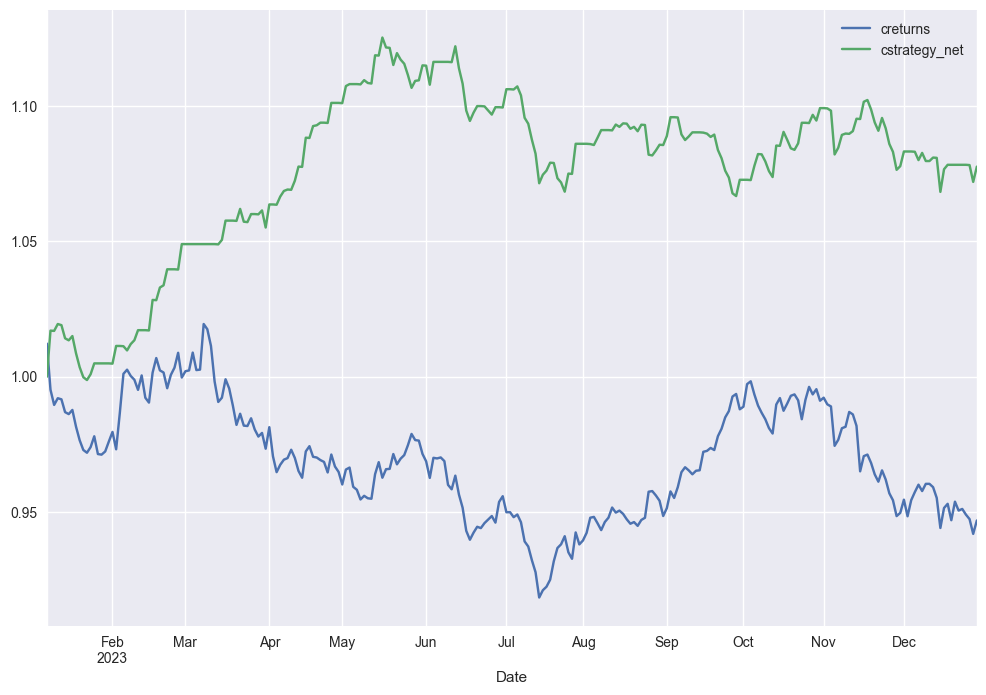

In [80]:
best = BollingerBandStrategy(df, 5, 1)

best.plot_data()